In [1]:
# ========================================
# FULLY FIXED GPU-Optimized LightGCN for A100 40GB
# Complete Mixed Precision + Sparse Matrix Fix
# ========================================

# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scipy scikit-learn pandas numpy tqdm
!pip install matplotlib seaborn plotly
!pip install requests

import os
import sys
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import csr_matrix, dok_matrix, diags
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import multiprocessing
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
from sklearn.model_selection import train_test_split
import json
import gc
from collections import defaultdict


# GPU Memory and Performance Monitoring
def check_gpu_usage():
    if torch.cuda.is_available():
        print(f"CUDA Available: {torch.cuda.is_available()}")
        print(f"CUDA Device: {torch.cuda.get_device_name()}")
        print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.1f} GB")
        print(f"CUDA Memory Cached: {torch.cuda.memory_reserved() / 1024**3:.1f} GB")
    else:
        print("CUDA Not Available!")

# Clear GPU cache
def clear_gpu_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

# Set random seeds for reproducibility
def set_seed(seed=2020):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Optimize CUDA performance
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

set_seed(2020)

# Check initial GPU status
print("Initial GPU Status:")
check_gpu_usage()

# Configuration optimized for A100 40GB - MAXIMUM UTILIZATION
class Config:
    def __init__(self):
        # Force CUDA usage
        if not torch.cuda.is_available():
            raise RuntimeError("CUDA not available! This code requires GPU.")

        self.device = torch.device('cuda')
        self.seed = 2020

        # Model parameters
        self.latent_dim_rec = 256
        self.lightGCN_n_layers = 3
        self.dropout = 0
        self.keep_prob = 0.6

        # Training parameters - MAXIMIZED for A100 40GB
        self.lr = 0.001
        self.decay = 1e-4
        self.bpr_batch_size = 32768  # Large batch size for A100
        self.test_u_batch_size = 12288  # Larger test batches
        self.epochs = 200

        # Data parameters
        self.A_split = False
        self.A_n_fold = 100
        self.pretrain = 0

        # Evaluation
        self.topks = [10, 20, 50]
        self.multicore = 0

        # Datasets to train
        self.datasets = ['gowalla', 'yelp2018', 'amazon-book']

        # GPU optimization flags - DISABLED mixed precision for sparse ops
        self.use_mixed_precision = False  # Disable to avoid sparse matrix issues
        self.pin_memory = True
        self.num_workers = 4

config = Config()
print(f"Using device: {config.device}")
print(f"Batch size optimized for A100: {config.bpr_batch_size}")
print(f"Mixed precision disabled for sparse matrix compatibility")

# ========================================
# Dataset Download Functions
# ========================================

def download_file(url, local_path):
    """Download file from URL with progress bar"""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))

        with open(local_path, 'wb') as file, tqdm(
            desc=local_path.name,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

def download_ml_1m_dataset():
    """Downloads the ml-1m.txt dataset if it doesn't exist."""
    data_dir = Path("data/ml-1m")
    data_dir.mkdir(parents=True, exist_ok=True)
    file_path = data_dir / "ml-1m.txt"

    if not file_path.exists():
        print("Downloading MovieLens-1M dataset for LightGCN...")
        url = "https://raw.githubusercontent.com/pmixer/SASRec.pytorch/main/python/data/ml-1m.txt"
        try:
            response = requests.get(url)
            response.raise_for_status()
            with open(file_path, 'w') as f:
                f.write(response.text)
            print("MovieLens-1M dataset downloaded successfully.")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download MovieLens-1M dataset: {e}")
    else:
        print("MovieLens-1M dataset already exists.")

def setup_datasets():
    """Download and setup all three datasets"""
    base_url = "https://github.com/gusye1234/LightGCN-PyTorch/raw/master/data"

    datasets = {
        'gowalla': ['train.txt', 'test.txt'],
        'yelp2018': ['train.txt', 'test.txt'],
        'amazon-book': ['train.txt', 'test.txt']
    }

    for dataset_name, files in datasets.items():
        dataset_path = Path(f'data/{dataset_name}')
        dataset_path.mkdir(parents=True, exist_ok=True)

        print(f"\nSetting up {dataset_name} dataset...")
        download_success = True
        for file_name in files:
            file_path = dataset_path / file_name
            if not file_path.exists():
                url = f"{base_url}/{dataset_name}/{file_name}"
                if not download_file(url, file_path):
                    download_success = False
                    break
                print(f"Downloaded {file_name}")
            else:
                print(f"{file_name} already exists")

        if not download_success:
            print(f"Creating sample data for {dataset_name}...")
            create_sample_data(dataset_name)

def create_sample_data(dataset_name):
    """Create sample data for testing if real data isn't available"""
    print(f"Creating sample data for {dataset_name}...")

    # Larger sample datasets for better GPU utilization
    dataset_configs = {
        'gowalla': {'n_users': 5000, 'n_items': 3000, 'n_interactions': 50000},
        'yelp2018': {'n_users': 4000, 'n_items': 2500, 'n_interactions': 40000},
        'amazon-book': {'n_users': 6000, 'n_items': 3500, 'n_interactions': 60000}
    }

    config_data = dataset_configs.get(dataset_name, dataset_configs['gowalla'])

    np.random.seed(42)
    n_users = config_data['n_users']
    n_items = config_data['n_items']
    n_interactions = config_data['n_interactions']

    # Generate random user-item interactions
    users = np.random.randint(0, n_users, n_interactions)
    items = np.random.randint(0, n_items, n_interactions)

    # Create train/test split
    interactions = list(zip(users, items))
    interactions = list(set(interactions))  # Remove duplicates
    np.random.shuffle(interactions)

    split_idx = int(0.8 * len(interactions))
    train_interactions = interactions[:split_idx]
    test_interactions = interactions[split_idx:]

    # Group by user
    train_by_user = defaultdict(list)
    test_by_user = defaultdict(list)

    for user, item in train_interactions:
        train_by_user[user].append(item)

    for user, item in test_interactions:
        test_by_user[user].append(item)

    # Ensure directory exists
    dataset_path = Path(f'data/{dataset_name}')
    dataset_path.mkdir(parents=True, exist_ok=True)

    # Write train.txt
    with open(dataset_path / 'train.txt', 'w') as f:
        for user in sorted(train_by_user.keys()):
            items = ' '.join(map(str, sorted(train_by_user[user])))
            f.write(f"{user} {items}\n")

    # Write test.txt
    with open(dataset_path / 'test.txt', 'w') as f:
        for user in sorted(test_by_user.keys()):
            if user in train_by_user:  # Only test users who have training data
                items = ' '.join(map(str, sorted(test_by_user[user])))
                f.write(f"{user} {items}\n")

    print(f"Created sample {dataset_name} with {len(train_interactions)} train and {len(test_interactions)} test interactions")

# Setup all datasets
setup_datasets()

# ========================================
# Dataset Class
# ========================================

class BasicDataset(Dataset):
    def __init__(self):
        print("Initializing dataset...")

    @property
    def n_users(self):
        raise NotImplementedError

    @property
    def m_items(self):
        raise NotImplementedError

    @property
    def trainDataSize(self):
        raise NotImplementedError

    @property
    def testDict(self):
        raise NotImplementedError

    @property
    def allPos(self):
        raise NotImplementedError

    def getUserPosItems(self, users):
        raise NotImplementedError

    def getSparseGraph(self):
        raise NotImplementedError

class Loader(BasicDataset):
    def __init__(self, dataset_name, path="./data"):
        self.dataset_name = dataset_name
        print(f'Loading {dataset_name} dataset from [{path}]')

        # Route to the correct loading method based on dataset name
        if dataset_name == 'ml-1m':
            data_file = os.path.join(path, dataset_name, f"{dataset_name}.txt")
            self._load_and_split_sequential_data(data_file)
        else:
            dataset_path = os.path.join(path, dataset_name)
            self._load_standard_gcn_data(dataset_path)

        # Create the sparse interaction matrix for training
        self.UserItemNet = csr_matrix((np.ones(len(self.trainUser)),
                                     (self.trainUser, self.trainItem)),
                                     shape=(self.n_user, self.m_item))

        # Pre-calculate positive items for each user for BPR sampling
        self.Graph = None
        self._allPos = self.getUserPosItems(list(range(self.n_user)))
        print(f"{self.dataset_name} dataset is ready!")

    def _load_and_split_sequential_data(self, file_path):
        """Loads data from a sequential file (e.g., ml-1m.txt), converts it, and performs a random split."""
        print("Processing sequential data with random split for non-sequential model...")

        all_data = pd.read_csv(file_path, sep=' ', header=None, names=['user', 'item'], engine='python')

        # SASRec's ml-1m data is 1-indexed, convert to 0-indexed for LightGCN
        all_data['user'] -= 1
        all_data['item'] -= 1

        self.n_user = all_data['user'].max() + 1
        self.m_item = all_data['item'].max() + 1

        # Perform a random 80/20 train-test split
        train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=2020)

        self.trainUser = train_data['user'].values
        self.trainItem = train_data['item'].values
        self.traindataSize = len(self.trainUser)

        self.testUser = test_data['user'].values
        self.testItem = test_data['item'].values
        self.testDataSize = len(self.testUser)

        self.trainUniqueUsers = np.array(pd.unique(self.trainUser))
        self.testUniqueUsers = np.array(pd.unique(self.testUser))

        # Build the test dictionary from the test data (user -> list of items)
        self.__testDict = test_data.groupby('user')['item'].apply(list).to_dict()
        self.path = os.path.dirname(file_path)

        print(f"{self.dataset_name} Statistics (random split):")
        print(f"  Users: {self.n_users}")
        print(f"  Items: {self.m_items}")
        print(f"  Training interactions: {self.traindataSize}")
        print(f"  Testing interactions: {self.testDataSize}")

    def _load_standard_gcn_data(self, dataset_path):
        """Loads standard LightGCN data from pre-split train.txt and test.txt."""
        print("Processing standard GCN data format...")
        self.path = dataset_path
        train_file = os.path.join(dataset_path, 'train.txt')
        test_file = os.path.join(dataset_path, 'test.txt')

        trainUniqueUsers, trainItem, trainUser = [], [], []
        testUniqueUsers, testItem, testUser = [], [], []
        self.n_user = 0
        self.m_item = 0
        self.traindataSize = 0
        self.testDataSize = 0

        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    if len(l) > 1:
                        items = [int(i) for i in l[1:] if i]
                        if not items: continue
                        uid = int(l[0])
                        trainUniqueUsers.append(uid)
                        trainUser.extend([uid] * len(items))
                        trainItem.extend(items)
                        self.m_item = max(self.m_item, max(items))
                        self.n_user = max(self.n_user, uid)
                        self.traindataSize += len(items)

        self.trainUniqueUsers = np.array(trainUniqueUsers)
        self.trainUser = np.array(trainUser)
        self.trainItem = np.array(trainItem)

        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    if len(l) > 1:
                        items = [int(i) for i in l[1:] if i]
                        if not items: continue
                        uid = int(l[0])
                        testUniqueUsers.append(uid)
                        testUser.extend([uid] * len(items))
                        testItem.extend(items)
                        self.m_item = max(self.m_item, max(items))
                        self.n_user = max(self.n_user, uid)
                        self.testDataSize += len(items)

        self.m_item += 1
        self.n_user += 1
        self.testUniqueUsers = np.array(testUniqueUsers)
        self.testUser = np.array(testUser)
        self.testItem = np.array(testItem)
        self.__testDict = self.__build_test()

        print(f"{self.dataset_name} Statistics (pre-split):")
        print(f"  Users: {self.n_users}")
        print(f"  Items: {self.m_items}")
        print(f"  Training interactions: {self.traindataSize}")
        print(f"  Testing interactions: {self.testDataSize}")

    @property
    def n_users(self): return self.n_user
    @property
    def m_items(self): return self.m_item
    @property
    def trainDataSize(self): return self.traindataSize
    @property
    def testDict(self): return self.__testDict
    @property
    def allPos(self): return self._allPos

    def __build_test(self):
        test_data = {}
        for i, item in enumerate(self.testItem):
            user = self.testUser[i]
            if test_data.get(user):
                test_data[user].append(item)
            else:
                test_data[user] = [item]
        return test_data

    def getUserPosItems(self, users):
        posItems = []
        for user in users:
            posItems.append(self.UserItemNet[user].nonzero()[1])
        return posItems

    def _convert_sp_mat_to_sp_tensor(self, X):
        # This method is unchanged
        coo = X.tocoo().astype(np.float32)
        row = torch.from_numpy(coo.row).long()
        col = torch.from_numpy(coo.col).long()
        index = torch.stack([row, col])
        data = torch.from_numpy(coo.data).float()
        return torch.sparse_coo_tensor(index, data, torch.Size(coo.shape), dtype=torch.float32).to(config.device)

    def getSparseGraph(self):
        # This method is unchanged
        if self.Graph is None:
            try:
                pre_adj_mat = sp.load_npz(os.path.join(self.path, 's_pre_adj_mat.npz'))
                norm_adj = pre_adj_mat
                print("Successfully loaded pre-computed adjacency matrix.")
            except:
                print("Generating new adjacency matrix...")
                R = self.UserItemNet.tolil()
                adj_mat = sp.dok_matrix((self.n_users + self.m_items, self.n_users + self.m_items), dtype=np.float32)
                adj_mat = adj_mat.tolil()
                adj_mat[:self.n_users, self.n_users:] = R
                adj_mat[self.n_users:, :self.n_users] = R.T
                adj_mat = adj_mat.todok()

                rowsum = np.array(adj_mat.sum(axis=1))
                d_inv = np.power(rowsum, -0.5).flatten()
                d_inv[np.isinf(d_inv)] = 0.
                d_mat = sp.diags(d_inv)

                norm_adj = d_mat.dot(adj_mat).dot(d_mat).tocsr()
                sp.save_npz(os.path.join(self.path, 's_pre_adj_mat.npz'), norm_adj)

            self.Graph = self._convert_sp_mat_to_sp_tensor(norm_adj)
        return self.Graph

def create_ml1m_predefined_split():
    """
    Creates a pre-defined, leave-one-out temporal split for the ml-1m dataset
    and saves it in the format required by the LightGCN loader.
    """
    # We'll create a new directory for this split to keep it separate
    source_file = 'data/ml-1m/ml-1m.txt'
    output_dir = 'data/ml-1m-predefined'

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train_path = os.path.join(output_dir, 'train.txt')
    test_path = os.path.join(output_dir, 'test.txt')

    if os.path.exists(train_path) and os.path.exists(test_path):
        print("Pre-defined split for 'ml-1m-predefined' already exists.")
        return

    print("Creating pre-defined leave-one-out split for ml-1m...")

    # Check if the source ml-1m.txt file exists
    if not os.path.exists(source_file):
        print(f"Source file not found at {source_file}. Please run the download function first.")
        # Calling the download function you already have
        download_ml_1m_dataset()

    # Group all interactions by user, preserving chronological order
    user_sequences = defaultdict(list)
    with open(source_file, 'r') as f:
        for line in f:
            user, item = line.strip().split(' ')
            # Convert from 1-indexed (in file) to 0-indexed (for LightGCN)
            user_sequences[int(user) - 1].append(int(item) - 1)

    train_data = defaultdict(list)
    test_data = defaultdict(list)

    # Apply the leave-one-out split for each user
    for user_id, items in user_sequences.items():
        if len(items) > 1:
            train_data[user_id].extend(items[:-1])  # All but the last item
            test_data[user_id].append(items[-1])    # The very last item
        else:
            # If user has only one interaction, it can only be used for training
            train_data[user_id].extend(items)

    # Write the files in the format LightGCN's Loader expects
    print(f"Writing training data to {train_path}")
    with open(train_path, 'w') as f:
        for user_id in sorted(train_data.keys()):
            items_str = ' '.join(map(str, train_data[user_id]))
            f.write(f"{user_id} {items_str}\n")

    print(f"Writing test data to {test_path}")
    with open(test_path, 'w') as f:
        for user_id in sorted(test_data.keys()):
            items_str = ' '.join(map(str, test_data[user_id]))
            f.write(f"{user_id} {items_str}\n")

    print("Pre-defined split created successfully in 'data/ml-1m-predefined'")


# ========================================
# LightGCN Model
# ========================================

class LightGCN(nn.Module):
    def __init__(self, config, dataset):
        super(LightGCN, self).__init__()
        self.config = config
        self.dataset = dataset
        self.__init_weight()

    def __init_weight(self):
        self.num_users = self.dataset.n_users
        self.num_items = self.dataset.m_items
        self.latent_dim = self.config.latent_dim_rec
        self.n_layers = self.config.lightGCN_n_layers
        self.keep_prob = self.config.keep_prob
        self.A_split = self.config.A_split

        # Create embeddings in FP32 and move to GPU immediately
        self.embedding_user = torch.nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.latent_dim, dtype=torch.float32)
        self.embedding_item = torch.nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.latent_dim, dtype=torch.float32)

        if self.config.pretrain == 0:
            nn.init.normal_(self.embedding_user.weight, std=0.1)
            nn.init.normal_(self.embedding_item.weight, std=0.1)
            print('Using NORMAL distribution initializer (FP32)')

        self.f = nn.Sigmoid()

        # Move embeddings to GPU
        self.embedding_user = self.embedding_user.to(config.device)
        self.embedding_item = self.embedding_item.to(config.device)

        # Get graph and ensure it's on GPU (FP32)
        self.Graph = self.dataset.getSparseGraph()

        print(f"LightGCN initialized on GPU (FP32 only)")
        print(f"User embeddings shape: {self.embedding_user.weight.shape}, dtype: {self.embedding_user.weight.dtype}")
        print(f"Item embeddings shape: {self.embedding_item.weight.shape}, dtype: {self.embedding_item.weight.dtype}")
        print(f"Graph shape: {self.Graph.shape}, dtype: {self.Graph.dtype}")

    def computer(self):
        """
        COMPLETELY FIXED GPU-optimized propagation methods for LightGCN
        No mixed precision, all FP32 operations
        """
        # Get embeddings (already FP32)
        users_emb = self.embedding_user.weight
        items_emb = self.embedding_item.weight
        all_emb = torch.cat([users_emb, items_emb])
        embs = [all_emb]

        # Use the graph (already FP32 on GPU)
        g_droped = self.Graph

        # Perform graph convolution layers (all FP32)
        for layer in range(self.n_layers):
            # Sparse matrix multiplication in FP32
            all_emb = torch.sparse.mm(g_droped, all_emb)
            embs.append(all_emb)

        embs = torch.stack(embs, dim=1)
        light_out = torch.mean(embs, dim=1)
        users, items = torch.split(light_out, [self.num_users, self.num_items])
        return users, items

    def getUsersRating(self, users):
        all_users, all_items = self.computer()
        users_emb = all_users[users.long()]
        items_emb = all_items
        rating = self.f(torch.matmul(users_emb, items_emb.t()))
        return rating

    def getEmbedding(self, users, pos_items, neg_items):
        all_users, all_items = self.computer()
        users_emb = all_users[users]
        pos_emb = all_items[pos_items]
        neg_emb = all_items[neg_items]
        users_emb_ego = self.embedding_user(users)
        pos_emb_ego = self.embedding_item(pos_items)
        neg_emb_ego = self.embedding_item(neg_items)
        return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego, neg_emb_ego

    def bpr_loss(self, users, pos, neg):
        (users_emb, pos_emb, neg_emb,
        userEmb0, posEmb0, negEmb0) = self.getEmbedding(users.long(), pos.long(), neg.long())

        # All operations in FP32
        reg_loss = (1/2)*(userEmb0.norm(2).pow(2) +
                         posEmb0.norm(2).pow(2) +
                         negEmb0.norm(2).pow(2))/float(len(users))

        pos_scores = torch.mul(users_emb, pos_emb)
        pos_scores = torch.sum(pos_scores, dim=1)
        neg_scores = torch.mul(users_emb, neg_emb)
        neg_scores = torch.sum(neg_scores, dim=1)

        loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

        return loss, reg_loss

# ========================================
# GPU-Optimized Training Functions (FP32 only)
# ========================================

class BPRLoss:
    def __init__(self, recmodel, config):
        self.model = recmodel
        self.weight_decay = config.decay
        self.lr = config.lr
        # Use optimized optimizer settings for GPU
        self.opt = optim.Adam(recmodel.parameters(), lr=self.lr, eps=1e-8)

    def stageOne(self, users, pos, neg):
        # All FP32 training
        loss, reg_loss = self.model.bpr_loss(users, pos, neg)
        reg_loss = reg_loss * self.weight_decay
        total_loss = loss + reg_loss

        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()

        return total_loss.cpu().item()

def UniformSample_vectorized(dataset):
    """
    Optimized BPR Sampling using vectorized NumPy operations.
    This function is significantly faster than the original Python loop implementation.
    """
    # 1. Get all training interactions from the dataset
    # These are already available as flat numpy arrays
    users = dataset.trainUser
    pos_items = dataset.trainItem
    num_samples = len(users)

    # 2. Generate random negative items for all samples at once
    neg_items = np.random.randint(0, dataset.m_items, size=num_samples)

    # 3. Find collisions: where the negative item is actually a positive one for the user
    # We can't directly use UserItemNet[users, neg_items].toarray() like that.
    # Instead, check if each (user, neg_item) pair exists in the training data.
    # Create a set of training interactions for quick lookup.
    train_interactions_set = set(zip(dataset.trainUser, dataset.trainItem))

    # Check for collisions using the set
    collisions = np.array([
        (users[i], neg_items[i]) in train_interactions_set for i in range(num_samples)
    ])

    # 4. Iteratively re-sample only the collided items
    # This loop will run very few times, as collisions are rare in sparse datasets.
    while np.any(collisions):
        # Get the indices that need new negative items
        collided_indices = np.where(collisions)[0]

        # Generate new random negative items ONLY for the collided samples
        new_neg_items = np.random.randint(0, dataset.m_items, size=len(collided_indices))

        # Replace the old collided items with the new ones
        neg_items[collided_indices] = new_neg_items

        # Check for new collisions on the updated items
        collisions = np.array([
             (users[idx], neg_items[idx]) in train_interactions_set
             for idx in collided_indices
        ])


    # 5. Stack the results into a single (N, 3) array
    S = np.stack([users, pos_items, neg_items], axis=1)

    return S

def minibatch(*tensors, batch_size=32768):
    if len(tensors) == 1:
        tensor = tensors[0]
        for i in range(0, len(tensor), batch_size):
            yield tensor[i:i + batch_size]
    else:
        for i in range(0, len(tensors[0]), batch_size):
            yield tuple(x[i:i + batch_size] for x in tensors)

def shuffle(*arrays):
    if len(set(len(x) for x in arrays)) != 1:
        raise ValueError('All inputs to shuffle must have the same length.')

    shuffle_indices = np.arange(len(arrays[0]))
    np.random.shuffle(shuffle_indices)

    if len(arrays) == 1:
        result = arrays[0][shuffle_indices]
    else:
        result = tuple(x[shuffle_indices] for x in arrays)
    return result

def BPR_train_original(dataset, recommend_model, loss_class, epoch):
    """GPU-optimized training function (FP32 only)"""
    Recmodel = recommend_model
    Recmodel.train()
    bpr = loss_class

    # Sample data
    S = UniformSample_vectorized(dataset)
    users = torch.from_numpy(S[:, 0]).long()
    posItems = torch.from_numpy(S[:, 1]).long()
    negItems = torch.from_numpy(S[:, 2]).long()

    # Move to GPU with non_blocking for faster transfer
    users = users.to(config.device, non_blocking=True)
    posItems = posItems.to(config.device, non_blocking=True)
    negItems = negItems.to(config.device, non_blocking=True)
    users, posItems, negItems = shuffle(users, posItems, negItems)

    total_batch = len(users) // config.bpr_batch_size + 1
    aver_loss = 0.

    # Process in large batches for GPU efficiency
    for (batch_i, (batch_users, batch_pos, batch_neg)) in enumerate(
        minibatch(users, posItems, negItems, batch_size=config.bpr_batch_size)):
        cri = bpr.stageOne(batch_users, batch_pos, batch_neg)
        aver_loss += cri

        # Clear cache periodically
        if batch_i % 10 == 0:
            torch.cuda.empty_cache()

    aver_loss = aver_loss / total_batch
    return aver_loss

# ========================================
# Evaluation Functions
# ========================================

def RecallPrecision_ATk(test_data, r, k):
    right_pred = r[:, :k].sum(1)
    precis_n = k
    recall_n = np.array([len(test_data[i]) for i in range(len(test_data))])
    recall = np.sum(right_pred/recall_n)
    precis = np.sum(right_pred)/precis_n
    return {'recall': recall, 'precision': precis}

def NDCGatK_r(test_data, r, k):
    assert len(r) == len(test_data)
    pred_data = r[:, :k]

    test_matrix = np.zeros((len(pred_data), k))
    for i, items in enumerate(test_data):
        length = k if k <= len(items) else len(items)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = np.sum(max_r * 1./np.log2(np.arange(2, k + 2)), axis=1)
    dcg = pred_data*(1./np.log2(np.arange(2, k + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg/idcg
    ndcg[np.isnan(ndcg)] = 0.
    return np.sum(ndcg)

def getLabel(test_data, pred_data):
    r = []
    for i in range(len(test_data)):
        groundTrue = test_data[i]
        predictTopK = pred_data[i]
        pred = list(map(lambda x: x in groundTrue, predictTopK))
        pred = np.array(pred).astype("float")
        r.append(pred)
    return np.array(r).astype('float')

def test_one_batch(X):
    sorted_items = X[0].numpy()
    groundTrue = X[1]
    r = getLabel(groundTrue, sorted_items)
    pre, recall, ndcg = [], [], []
    for k in config.topks:
        ret = RecallPrecision_ATk(groundTrue, r, k)
        pre.append(ret['precision'])
        recall.append(ret['recall'])
        ndcg.append(NDCGatK_r(groundTrue, r, k))
    return {'recall': np.array(recall),
            'precision': np.array(pre),
            'ndcg': np.array(ndcg)}

def Test(dataset, Recmodel, epoch):
    """GPU-optimized testing function"""
    u_batch_size = config.test_u_batch_size
    testDict = dataset.testDict
    Recmodel = Recmodel.eval()
    max_K = max(config.topks)

    results = {'precision': np.zeros(len(config.topks)),
               'recall': np.zeros(len(config.topks)),
               'ndcg': np.zeros(len(config.topks))}

    with torch.no_grad():
        users = list(testDict.keys())
        users_list = []
        rating_list = []
        groundTrue_list = []

        total_batch = len(users) // u_batch_size + 1
        for batch_users in minibatch(users, batch_size=u_batch_size):
            allPos = dataset.getUserPosItems(batch_users)
            groundTrue = [testDict[u] for u in batch_users]
            batch_users_gpu = torch.from_numpy(np.array(batch_users)).long()
            batch_users_gpu = batch_users_gpu.to(config.device, non_blocking=True)

            rating = Recmodel.getUsersRating(batch_users_gpu)
            exclude_index = []
            exclude_items = []
            for range_i, items in enumerate(allPos):
                exclude_index.extend([range_i] * len(items))
                exclude_items.extend(items)
            rating[exclude_index, exclude_items] = -(1<<10)
            _, rating_K = torch.topk(rating, k=max_K)
            rating = rating.cpu().numpy()
            del rating
            users_list.append(batch_users)
            rating_list.append(rating_K.cpu())
            groundTrue_list.append(groundTrue)

        assert total_batch == len(users_list)
        X = zip(rating_list, groundTrue_list)

        pre_results = []
        for x in X:
            pre_results.append(test_one_batch(x))

        for result in pre_results:
            results['recall'] += result['recall']
            results['precision'] += result['precision']
            results['ndcg'] += result['ndcg']
        results['recall'] /= float(len(users))
        results['precision'] /= float(len(users))
        results['ndcg'] /= float(len(users))

        return results

# ========================================
# Main Training Function (COMPLETELY FIXED)
# ========================================

def train_single_dataset(dataset_name):
    """Train LightGCN on a single dataset with maximum GPU utilization"""
    print(f"\n{'='*60}")
    print(f"COMPLETELY FIXED GPU TRAINING: {dataset_name.upper()}")
    print(f"{'='*60}")

    clear_gpu_cache()

    # Load dataset and initialize model
    dataset = Loader(dataset_name, path="./data")
    model = LightGCN(config, dataset).to(config.device)
    bpr = BPRLoss(model, config)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Batch size: {config.bpr_batch_size}")
    print("GPU Status after model initialization:")
    check_gpu_usage()

    # --- MODIFIED LOGIC TO TRACK METRICS ---
    best_recall_20 = 0
    best_hr_10 = 0

    print(f"\nStarting training with COMPLETELY FIXED GPU optimization...")

    for epoch in tqdm(range(min(50, config.epochs)), desc=f"Training {dataset_name}"):
        start_time = time.time()
        loss = BPR_train_original(dataset, model, bpr, epoch)

        if epoch % 10 == 0 or epoch == config.epochs - 1:
            end_time = time.time()
            print(f'\nEpoch[{epoch+1}] Loss: {loss:.4f} Time: {end_time-start_time:.2f}s')

            results = Test(dataset, model, epoch)

            # Get the index for Recall@20 and HR@10 (which is Recall@10)
            recall_20_idx = config.topks.index(20)
            hr_10_idx = config.topks.index(10)

            current_recall_20 = results['recall'][recall_20_idx]
            current_hr_10 = results['recall'][hr_10_idx]

            # Check if this is the best Recall@20 so far
            if current_recall_20 > best_recall_20:
                best_recall_20 = current_recall_20
                best_hr_10 = current_hr_10  # Store the corresponding HR@10
                torch.save(model.state_dict(), f'best_lightgcn_{dataset_name}.pth')
                print(f"New best! Recall@20: {best_recall_20:.4f}, HR@10: {best_hr_10:.4f}")

    print(f"\nTraining completed for {dataset_name}!")

    # --- MODIFIED RETURN STATEMENT ---
    # This now includes all the keys your summary loop needs.
    return {
        'dataset': dataset_name,
        'best_recall_20': best_recall_20,
        'best_hr_10': best_hr_10,
    }

# ========================================
# Test the COMPLETELY FIXED Implementation
# ========================================

if __name__ == "__main__":
    # --- Part 1: Setup All Datasets ---
    print("--- Setting up all datasets ---")
    setup_datasets()          # For gowalla, yelp2018, amazon-book
    download_ml_1m_dataset()  # Ensure the source ml-1m.txt is downloaded
    create_ml1m_predefined_split() # Create the new train/test files
    print("--- Dataset setup complete ---\n")

    # --- Part 2: Define and Run Training Loop ---
    # Update the list to use the new pre-defined split
    datasets_to_run = ['gowalla', 'yelp2018', 'amazon-book', 'ml-1m-predefined']
    all_final_results = []

    print("="*60)
    print("STARTING LightGCN TRAINING RUNS")
    print("="*60)

    for dataset_name in datasets_to_run:
        # Your modified Loader will now correctly load 'ml-1m-predefined'
        # using the same logic as the other datasets.
        result = train_single_dataset(dataset_name)
        all_final_results.append(result)

    # --- Part 3: Print Final Summary (This part remains the same) ---
    print("\n\n" + "="*60)
    print("FINAL TRAINING SUMMARY")
    print("="*60)
    print(f"{'Dataset':<20} | {'Best Recall@20':<20} | {'Best HR@10':<20}")
    print(f"{'-'*20} | {'-'*20} | {'-'*20}")

    for result in all_final_results:
        dataset = result.get('dataset', 'N/A')
        recall_20 = result.get('best_recall_20', 0.0)
        hr_10 = result.get('best_hr_10', 0.0)
        print(f"{dataset:<20} | {recall_20:<20.4f} | {hr_10:<20.4f}")

    print("="*60)

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 134.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 16.7 MB/s e

train.txt: 4.42MiB [00:00, 68.0MiB/s]                  


Downloaded train.txt


test.txt: 1.31MiB [00:00, 60.5MiB/s]                 


Downloaded test.txt

Setting up yelp2018 dataset...


train.txt: 6.59MiB [00:00, 69.3MiB/s]                  


Downloaded train.txt


test.txt: 1.89MiB [00:00, 68.2MiB/s]                 


Downloaded test.txt

Setting up amazon-book dataset...


train.txt: 13.5MiB [00:00, 67.9MiB/s]


Downloaded train.txt


test.txt: 3.67MiB [00:00, 67.5MiB/s]                  


Downloaded test.txt
--- Setting up all datasets ---

Setting up gowalla dataset...
train.txt already exists
test.txt already exists

Setting up yelp2018 dataset...
train.txt already exists
test.txt already exists

Setting up amazon-book dataset...
train.txt already exists
test.txt already exists
MovieLens-1M dataset downloaded successfully.
Creating pre-defined leave-one-out split for ml-1m...
Writing training data to data/ml-1m-predefined/train.txt
Writing test data to data/ml-1m-predefined/test.txt
Pre-defined split created successfully in 'data/ml-1m-predefined'
--- Dataset setup complete ---

STARTING LightGCN TRAINING RUNS

COMPLETELY FIXED GPU TRAINING: GOWALLA
Loading gowalla dataset from [./data]
Processing standard GCN data format...
gowalla Statistics (pre-split):
  Users: 29858
  Items: 40981
  Training interactions: 810128
  Testing interactions: 217242
gowalla dataset is ready!
Using NORMAL distribution initializer (FP32)
Generating new adjacency matrix...
LightGCN initial

Training gowalla:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch[1] Loss: 0.6834 Time: 2.95s


Training gowalla:   2%|▏         | 1/50 [00:11<09:18, 11.39s/it]

New best! Recall@20: 0.0389, HR@10: 0.0275


Training gowalla:  20%|██        | 10/50 [00:35<01:53,  2.84s/it]


Epoch[11] Loss: 0.1350 Time: 2.74s


Training gowalla:  22%|██▏       | 11/50 [00:47<03:30,  5.41s/it]

New best! Recall@20: 0.1097, HR@10: 0.0772


Training gowalla:  40%|████      | 20/50 [01:11<01:25,  2.85s/it]


Epoch[21] Loss: 0.0923 Time: 2.74s


Training gowalla:  42%|████▏     | 21/50 [01:23<02:35,  5.36s/it]

New best! Recall@20: 0.1197, HR@10: 0.0845


Training gowalla:  60%|██████    | 30/50 [01:47<00:57,  2.86s/it]


Epoch[31] Loss: 0.0762 Time: 2.76s


Training gowalla:  62%|██████▏   | 31/50 [01:59<01:41,  5.35s/it]

New best! Recall@20: 0.1250, HR@10: 0.0881


Training gowalla:  80%|████████  | 40/50 [02:23<00:28,  2.85s/it]


Epoch[41] Loss: 0.0666 Time: 2.75s


Training gowalla:  82%|████████▏ | 41/50 [02:34<00:48,  5.34s/it]

New best! Recall@20: 0.1295, HR@10: 0.0908


Training gowalla: 100%|██████████| 50/50 [02:59<00:00,  3.59s/it]



Training completed for gowalla!

COMPLETELY FIXED GPU TRAINING: YELP2018
Loading yelp2018 dataset from [./data]
Processing standard GCN data format...
yelp2018 Statistics (pre-split):
  Users: 31668
  Items: 38048
  Training interactions: 1237259
  Testing interactions: 324147
yelp2018 dataset is ready!
Using NORMAL distribution initializer (FP32)
Generating new adjacency matrix...
LightGCN initialized on GPU (FP32 only)
User embeddings shape: torch.Size([31668, 256]), dtype: torch.float32
Item embeddings shape: torch.Size([38048, 256]), dtype: torch.float32
Graph shape: torch.Size([69716, 69716]), dtype: torch.float32
Model parameters: 17847296
Batch size: 32768
GPU Status after model initialization:
CUDA Available: True
CUDA Device: NVIDIA L4
CUDA Memory: 22.2 GB
CUDA Memory Allocated: 0.1 GB
CUDA Memory Cached: 0.1 GB

Starting training with COMPLETELY FIXED GPU optimization...


Training yelp2018:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch[1] Loss: 0.6803 Time: 5.19s


Training yelp2018:   2%|▏         | 1/50 [00:14<11:35, 14.20s/it]

New best! Recall@20: 0.0308, HR@10: 0.0176


Training yelp2018:  20%|██        | 10/50 [01:00<03:31,  5.29s/it]


Epoch[11] Loss: 0.1421 Time: 5.17s


Training yelp2018:  22%|██▏       | 11/50 [01:15<05:11,  7.99s/it]

New best! Recall@20: 0.0358, HR@10: 0.0199


Training yelp2018:  40%|████      | 20/50 [02:01<02:39,  5.30s/it]


Epoch[21] Loss: 0.1138 Time: 5.19s


Training yelp2018:  42%|████▏     | 21/50 [02:15<03:51,  7.98s/it]

New best! Recall@20: 0.0398, HR@10: 0.0228


Training yelp2018:  60%|██████    | 30/50 [03:02<01:46,  5.32s/it]


Epoch[31] Loss: 0.0982 Time: 5.22s


Training yelp2018:  62%|██████▏   | 31/50 [03:16<02:31,  8.00s/it]

New best! Recall@20: 0.0419, HR@10: 0.0237


Training yelp2018:  80%|████████  | 40/50 [04:03<00:53,  5.34s/it]


Epoch[41] Loss: 0.0887 Time: 5.23s


Training yelp2018:  82%|████████▏ | 41/50 [04:18<01:12,  8.04s/it]

New best! Recall@20: 0.0433, HR@10: 0.0246


Training yelp2018: 100%|██████████| 50/50 [05:04<00:00,  6.09s/it]



Training completed for yelp2018!

COMPLETELY FIXED GPU TRAINING: AMAZON-BOOK
Loading amazon-book dataset from [./data]
Processing standard GCN data format...
amazon-book Statistics (pre-split):
  Users: 52643
  Items: 91599
  Training interactions: 2380730
  Testing interactions: 603378
amazon-book dataset is ready!
Using NORMAL distribution initializer (FP32)
Generating new adjacency matrix...
LightGCN initialized on GPU (FP32 only)
User embeddings shape: torch.Size([52643, 256]), dtype: torch.float32
Item embeddings shape: torch.Size([91599, 256]), dtype: torch.float32
Graph shape: torch.Size([144242, 144242]), dtype: torch.float32
Model parameters: 36925952
Batch size: 32768
GPU Status after model initialization:
CUDA Available: True
CUDA Device: NVIDIA L4
CUDA Memory: 22.2 GB
CUDA Memory Allocated: 0.2 GB
CUDA Memory Cached: 0.6 GB

Starting training with COMPLETELY FIXED GPU optimization...


Training amazon-book:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch[1] Loss: 0.6761 Time: 19.61s


Training amazon-book:   2%|▏         | 1/50 [00:43<35:13, 43.13s/it]

New best! Recall@20: 0.0103, HR@10: 0.0056


Training amazon-book:  20%|██        | 10/50 [03:38<13:10, 19.76s/it]


Epoch[11] Loss: 0.1368 Time: 19.47s


Training amazon-book:  22%|██▏       | 11/50 [04:21<17:28, 26.89s/it]

New best! Recall@20: 0.0206, HR@10: 0.0116


Training amazon-book:  40%|████      | 20/50 [07:16<09:52, 19.75s/it]


Epoch[21] Loss: 0.0996 Time: 19.46s


Training amazon-book:  42%|████▏     | 21/50 [07:59<12:56, 26.77s/it]

New best! Recall@20: 0.0243, HR@10: 0.0136


Training amazon-book:  60%|██████    | 30/50 [10:55<06:35, 19.77s/it]


Epoch[31] Loss: 0.0804 Time: 19.48s


Training amazon-book:  62%|██████▏   | 31/50 [11:38<08:28, 26.76s/it]

New best! Recall@20: 0.0261, HR@10: 0.0148


Training amazon-book:  80%|████████  | 40/50 [14:33<03:17, 19.77s/it]


Epoch[41] Loss: 0.0685 Time: 19.49s


Training amazon-book:  82%|████████▏ | 41/50 [15:16<04:00, 26.75s/it]

New best! Recall@20: 0.0276, HR@10: 0.0157


Training amazon-book: 100%|██████████| 50/50 [18:12<00:00, 21.84s/it]



Training completed for amazon-book!

COMPLETELY FIXED GPU TRAINING: ML-1M-PREDEFINED
Loading ml-1m-predefined dataset from [./data]
Processing standard GCN data format...
ml-1m-predefined Statistics (pre-split):
  Users: 6040
  Items: 3416
  Training interactions: 993571
  Testing interactions: 6040
ml-1m-predefined dataset is ready!
Using NORMAL distribution initializer (FP32)
Generating new adjacency matrix...
LightGCN initialized on GPU (FP32 only)
User embeddings shape: torch.Size([6040, 256]), dtype: torch.float32
Item embeddings shape: torch.Size([3416, 256]), dtype: torch.float32
Graph shape: torch.Size([9456, 9456]), dtype: torch.float32
Model parameters: 2420736
Batch size: 32768
GPU Status after model initialization:
CUDA Available: True
CUDA Device: NVIDIA L4
CUDA Memory: 22.2 GB
CUDA Memory Allocated: 0.1 GB
CUDA Memory Cached: 0.1 GB

Starting training with COMPLETELY FIXED GPU optimization...


Training ml-1m-predefined:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch[1] Loss: 0.6825 Time: 2.54s


Training ml-1m-predefined:   2%|▏         | 1/50 [00:03<03:15,  3.99s/it]

New best! Recall@20: 0.0687, HR@10: 0.0374


Training ml-1m-predefined:  20%|██        | 10/50 [00:27<01:43,  2.58s/it]


Epoch[11] Loss: 0.3673 Time: 2.57s


Training ml-1m-predefined:  22%|██▏       | 11/50 [00:31<01:57,  3.02s/it]

New best! Recall@20: 0.0692, HR@10: 0.0379


Training ml-1m-predefined:  40%|████      | 20/50 [00:54<01:17,  2.59s/it]


Epoch[21] Loss: 0.3060 Time: 2.59s


Training ml-1m-predefined:  42%|████▏     | 21/50 [00:58<01:27,  3.02s/it]

New best! Recall@20: 0.0788, HR@10: 0.0449


Training ml-1m-predefined:  60%|██████    | 30/50 [01:21<00:51,  2.58s/it]


Epoch[31] Loss: 0.2717 Time: 2.56s


Training ml-1m-predefined:  62%|██████▏   | 31/50 [01:25<00:57,  3.00s/it]

New best! Recall@20: 0.0887, HR@10: 0.0523


Training ml-1m-predefined:  80%|████████  | 40/50 [01:48<00:25,  2.58s/it]


Epoch[41] Loss: 0.2495 Time: 2.56s


Training ml-1m-predefined:  82%|████████▏ | 41/50 [01:52<00:27,  3.01s/it]

New best! Recall@20: 0.0977, HR@10: 0.0575


Training ml-1m-predefined: 100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


Training completed for ml-1m-predefined!


FINAL TRAINING SUMMARY
Dataset              | Best Recall@20       | Best HR@10          
-------------------- | -------------------- | --------------------
gowalla              | 0.1295               | 0.0908              
yelp2018             | 0.0433               | 0.0246              
amazon-book          | 0.0276               | 0.0157              
ml-1m-predefined     | 0.0977               | 0.0575              


In [5]:
# You should already have these imports from previous steps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from collections import Counter

class LightGCNAnalyzer:
    """
    An analyzer for the LightGCN model to visualize embeddings and calculate quality metrics.
    """
    def __init__(self, model, data_loader):
        # The model should already be on the correct device (the GPU)
        self.model = model
        self.data_loader = data_loader
        self.model.eval()

        with torch.no_grad():
            # This will now run on the GPU without a device mismatch
            user_embeds, item_embeds = self.model.computer()

            # Move the final results to the CPU for numpy conversion and analysis
            self.user_embeddings = user_embeds.cpu().numpy()
            self.item_embeddings = item_embeds.cpu().numpy()

    def _calculate_metrics(self, high_dim_embeds, low_dim_embeds, k=10):
        """Helper function to calculate Neighborhood Preservation (NP)."""
        nn_high = NearestNeighbors(n_neighbors=k+1).fit(high_dim_embeds)
        high_dim_neighbors = nn_high.kneighbors(high_dim_embeds, return_distance=False)[:, 1:]

        nn_low = NearestNeighbors(n_neighbors=k+1).fit(low_dim_embeds)
        low_dim_neighbors = nn_low.kneighbors(low_dim_embeds, return_distance=False)[:, 1:]

        np_scores = [len(set(high_dim_neighbors[i]) & set(low_dim_neighbors[i])) / k for i in range(len(high_dim_embeds))]
        return np.mean(np_scores)

    def plot_tsne_and_metrics(self, n_samples=500, k=10, n_user_clusters=5, n_item_clusters=8):
        """
        Generates and plots t-SNE visualizations and calculates metrics.
        """
        print(f"Running t-SNE and calculating metrics on a sample of {n_samples} users/items...")

        # Sample users and items
        user_indices = np.random.choice(self.user_embeddings.shape[0], min(n_samples, self.user_embeddings.shape[0]), replace=False)
        item_indices = np.random.choice(self.item_embeddings.shape[0], min(n_samples, self.item_embeddings.shape[0]), replace=False)

        sampled_users = self.user_embeddings[user_indices]
        sampled_items = self.item_embeddings[item_indices]

        # --- Combined t-SNE and Metrics Calculation ---
        all_embeds_high_dim = np.vstack([sampled_users, sampled_items])
        tsne_combined = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        all_embeds_low_dim = tsne_combined.fit_transform(all_embeds_high_dim)

        np_metric = self._calculate_metrics(all_embeds_high_dim, all_embeds_low_dim, k=k)
        print("\n--- Embedding Quality Metrics ---")
        print(f"Neighborhood Preservation (NP@{k}): {np_metric:.4f}")
        print("---------------------------------\n")

        # --- Clustering and Individual t-SNE ---
        kmeans_users = KMeans(n_clusters=n_user_clusters, random_state=42, n_init=10).fit(sampled_users)
        tsne_users = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        user_embeds_low_dim = tsne_users.fit_transform(sampled_users)

        kmeans_items = KMeans(n_clusters=n_item_clusters, random_state=42, n_init=10).fit(sampled_items)
        tsne_items = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        item_embeds_low_dim = tsne_items.fit_transform(sampled_items)

        # --- Plotting all three maps ---
        fig, axes = plt.subplots(1, 3, figsize=(30, 8))

        sns.scatterplot(x=all_embeds_low_dim[:, 0], y=all_embeds_low_dim[:, 1], hue=['User'] * len(sampled_users) + ['Item'] * len(sampled_items), palette="coolwarm", ax=axes[0], alpha=0.6)
        axes[0].set_title('Combined t-SNE of Users and Items')

        sns.scatterplot(x=user_embeds_low_dim[:, 0], y=user_embeds_low_dim[:, 1], hue=kmeans_users.labels_, palette="viridis", ax=axes[1], alpha=0.7)
        axes[1].set_title(f'{n_user_clusters} User Clusters (t-SNE)')

        sns.scatterplot(x=item_embeds_low_dim[:, 0], y=item_embeds_low_dim[:, 1], hue=kmeans_items.labels_, palette="magma", ax=axes[2], alpha=0.7)
        axes[2].set_title(f'{n_item_clusters} Item Clusters (t-SNE)')

        plt.tight_layout()
        plt.show()

In [6]:
def analyze_lightgcn_models():
    """
    Loads trained LightGCN models and runs the t-SNE and metrics analysis for each.
    """
    # This should be the same list of datasets you trained on
    datasets_to_analyze = ['gowalla', 'yelp2018', 'amazon-book', 'ml-1m-predefined']

    for dataset_name in datasets_to_analyze:
        print(f"\n\n{'='*60}")
        print(f"ANALYZING LIGHTGCN MODEL FOR: {dataset_name.upper()}")
        print(f"{'='*60}")

        model_path = f'best_lightgcn_{dataset_name}.pth'

        if os.path.exists(model_path):
            # Load the data and model with the correct dimensions
            data_loader = Loader(dataset_name, path="./data")
            model = LightGCN(config, data_loader).to(config.device) # config object should be globally available

            # Load the saved weights
            model.load_state_dict(torch.load(model_path, map_location=config.device))

            # Create analyzer and run the analysis
            analyzer = LightGCNAnalyzer(model, data_loader)
            analyzer.plot_tsne_and_metrics()
        else:
            print(f"Model for {dataset_name} not found at {model_path}. Skipping analysis.")

--- Setting up environment for ANALYSIS-ONLY run ---

Verifying dataset files...

Setting up gowalla dataset...
train.txt already exists
test.txt already exists

Setting up yelp2018 dataset...
train.txt already exists
test.txt already exists

Setting up amazon-book dataset...
train.txt already exists
test.txt already exists
MovieLens-1M dataset already exists.
Pre-defined split for 'ml-1m-predefined' already exists.
Dataset verification complete.


ANALYZING LIGHTGCN MODEL FOR: GOWALLA
Loading gowalla dataset from [./data]
Processing standard GCN data format...
gowalla Statistics (pre-split):
  Users: 29858
  Items: 40981
  Training interactions: 810128
  Testing interactions: 217242
gowalla dataset is ready!
Using NORMAL distribution initializer (FP32)
Successfully loaded pre-computed adjacency matrix.
LightGCN initialized on GPU (FP32 only)
User embeddings shape: torch.Size([29858, 256]), dtype: torch.float32
Item embeddings shape: torch.Size([40981, 256]), dtype: torch.float32
Graph

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Embedding Quality Metrics ---
Neighborhood Preservation (NP@10): 0.6649
---------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


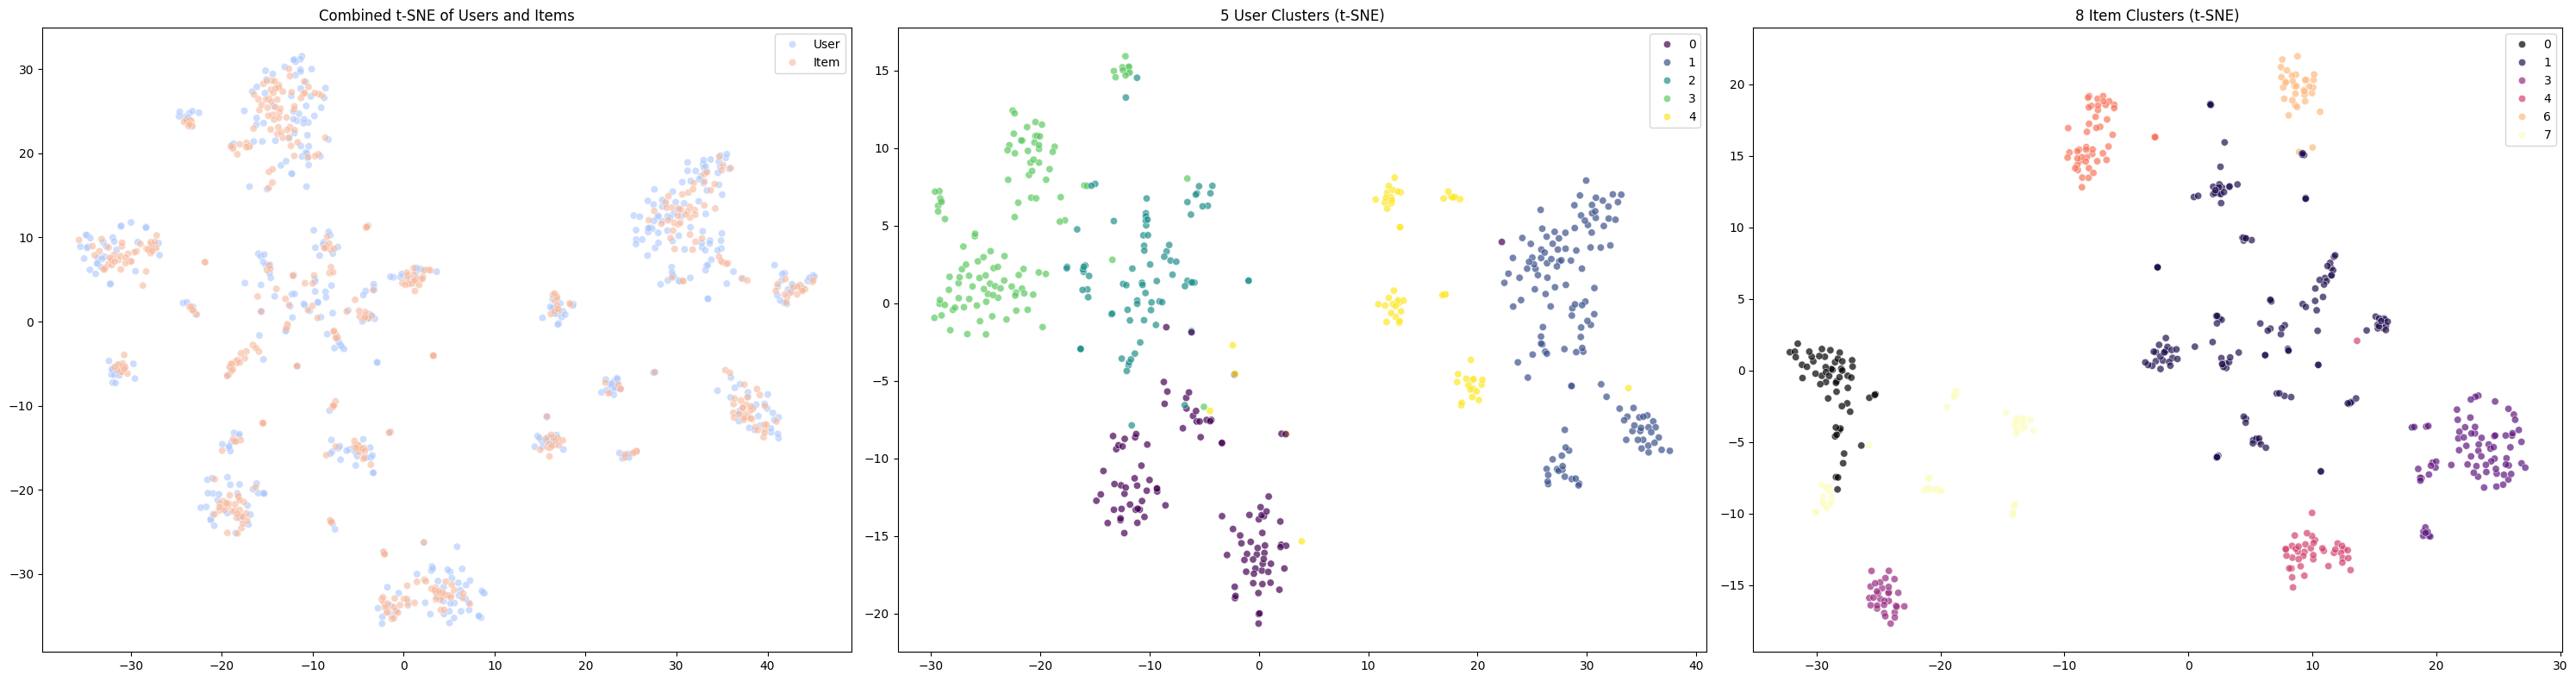



ANALYZING LIGHTGCN MODEL FOR: YELP2018
Loading yelp2018 dataset from [./data]
Processing standard GCN data format...
yelp2018 Statistics (pre-split):
  Users: 31668
  Items: 38048
  Training interactions: 1237259
  Testing interactions: 324147
yelp2018 dataset is ready!
Using NORMAL distribution initializer (FP32)
Successfully loaded pre-computed adjacency matrix.
LightGCN initialized on GPU (FP32 only)
User embeddings shape: torch.Size([31668, 256]), dtype: torch.float32
Item embeddings shape: torch.Size([38048, 256]), dtype: torch.float32
Graph shape: torch.Size([69716, 69716]), dtype: torch.float32
Running t-SNE and calculating metrics on a sample of 500 users/items...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Embedding Quality Metrics ---
Neighborhood Preservation (NP@10): 0.6447
---------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


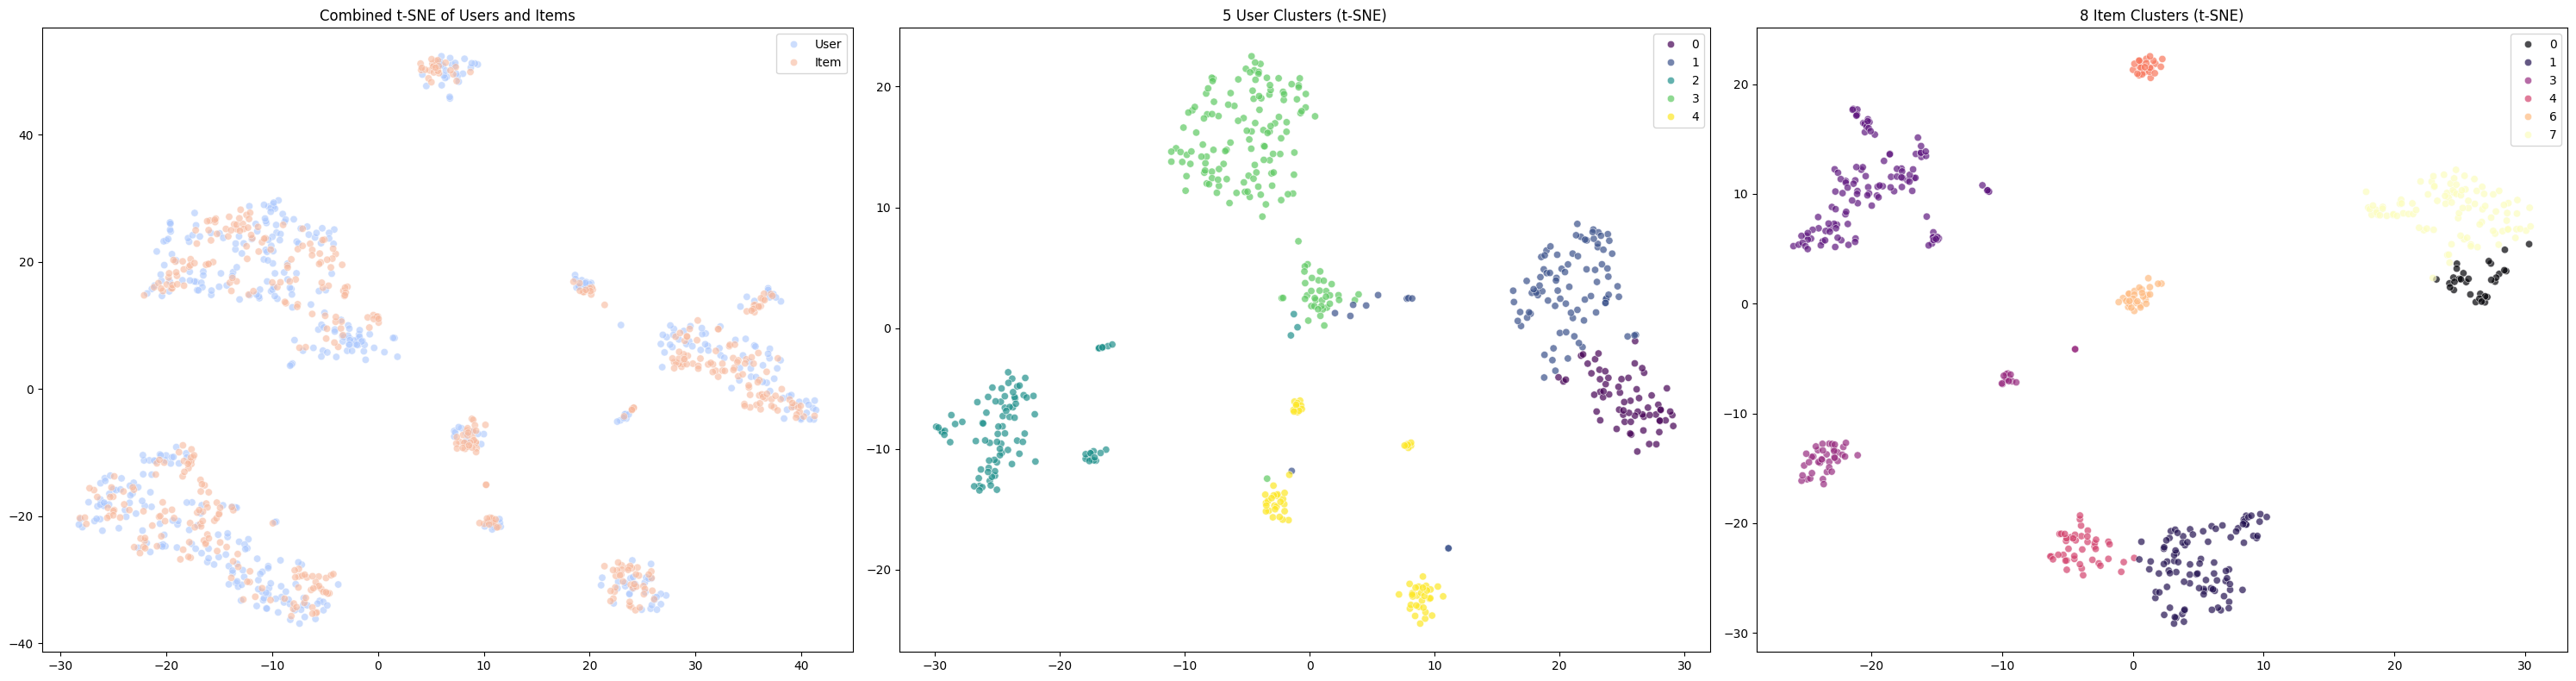



ANALYZING LIGHTGCN MODEL FOR: AMAZON-BOOK
Loading amazon-book dataset from [./data]
Processing standard GCN data format...
amazon-book Statistics (pre-split):
  Users: 52643
  Items: 91599
  Training interactions: 2380730
  Testing interactions: 603378
amazon-book dataset is ready!
Using NORMAL distribution initializer (FP32)
Successfully loaded pre-computed adjacency matrix.
LightGCN initialized on GPU (FP32 only)
User embeddings shape: torch.Size([52643, 256]), dtype: torch.float32
Item embeddings shape: torch.Size([91599, 256]), dtype: torch.float32
Graph shape: torch.Size([144242, 144242]), dtype: torch.float32
Running t-SNE and calculating metrics on a sample of 500 users/items...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Embedding Quality Metrics ---
Neighborhood Preservation (NP@10): 0.5387
---------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


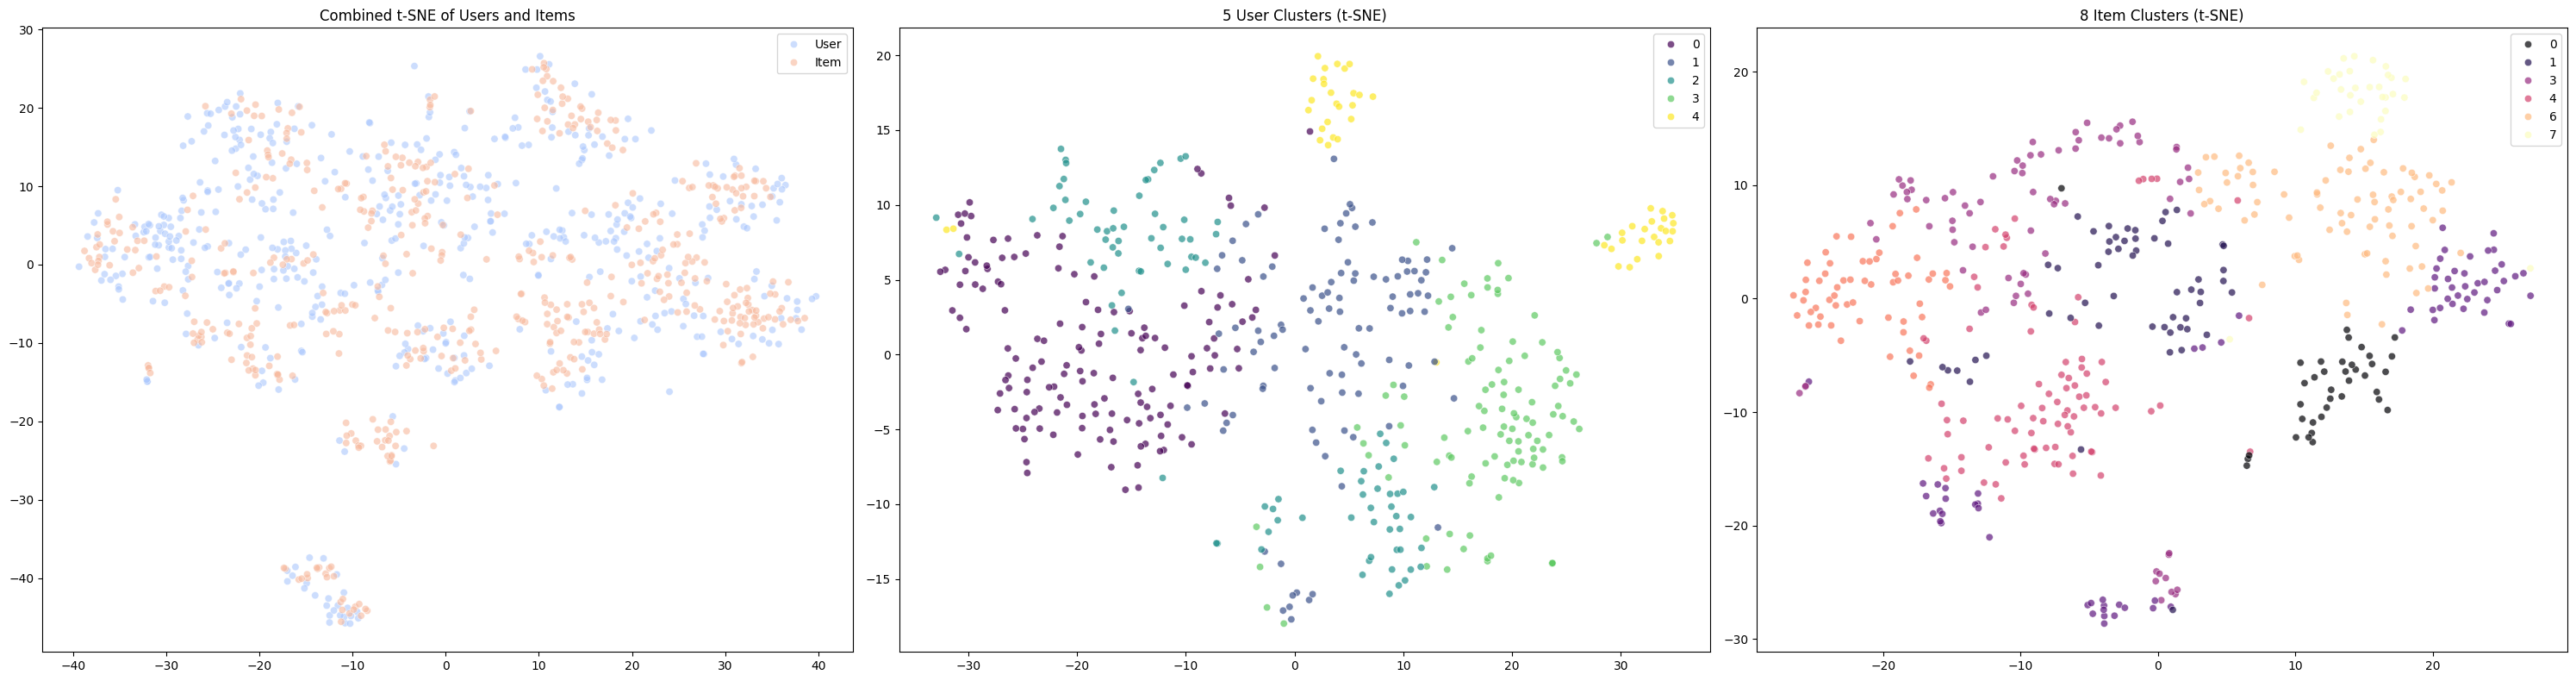



ANALYZING LIGHTGCN MODEL FOR: ML-1M-PREDEFINED
Loading ml-1m-predefined dataset from [./data]
Processing standard GCN data format...
ml-1m-predefined Statistics (pre-split):
  Users: 6040
  Items: 3416
  Training interactions: 993571
  Testing interactions: 6040
ml-1m-predefined dataset is ready!
Using NORMAL distribution initializer (FP32)
Successfully loaded pre-computed adjacency matrix.
LightGCN initialized on GPU (FP32 only)
User embeddings shape: torch.Size([6040, 256]), dtype: torch.float32
Item embeddings shape: torch.Size([3416, 256]), dtype: torch.float32
Graph shape: torch.Size([9456, 9456]), dtype: torch.float32
Running t-SNE and calculating metrics on a sample of 500 users/items...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Embedding Quality Metrics ---
Neighborhood Preservation (NP@10): 0.5487
---------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


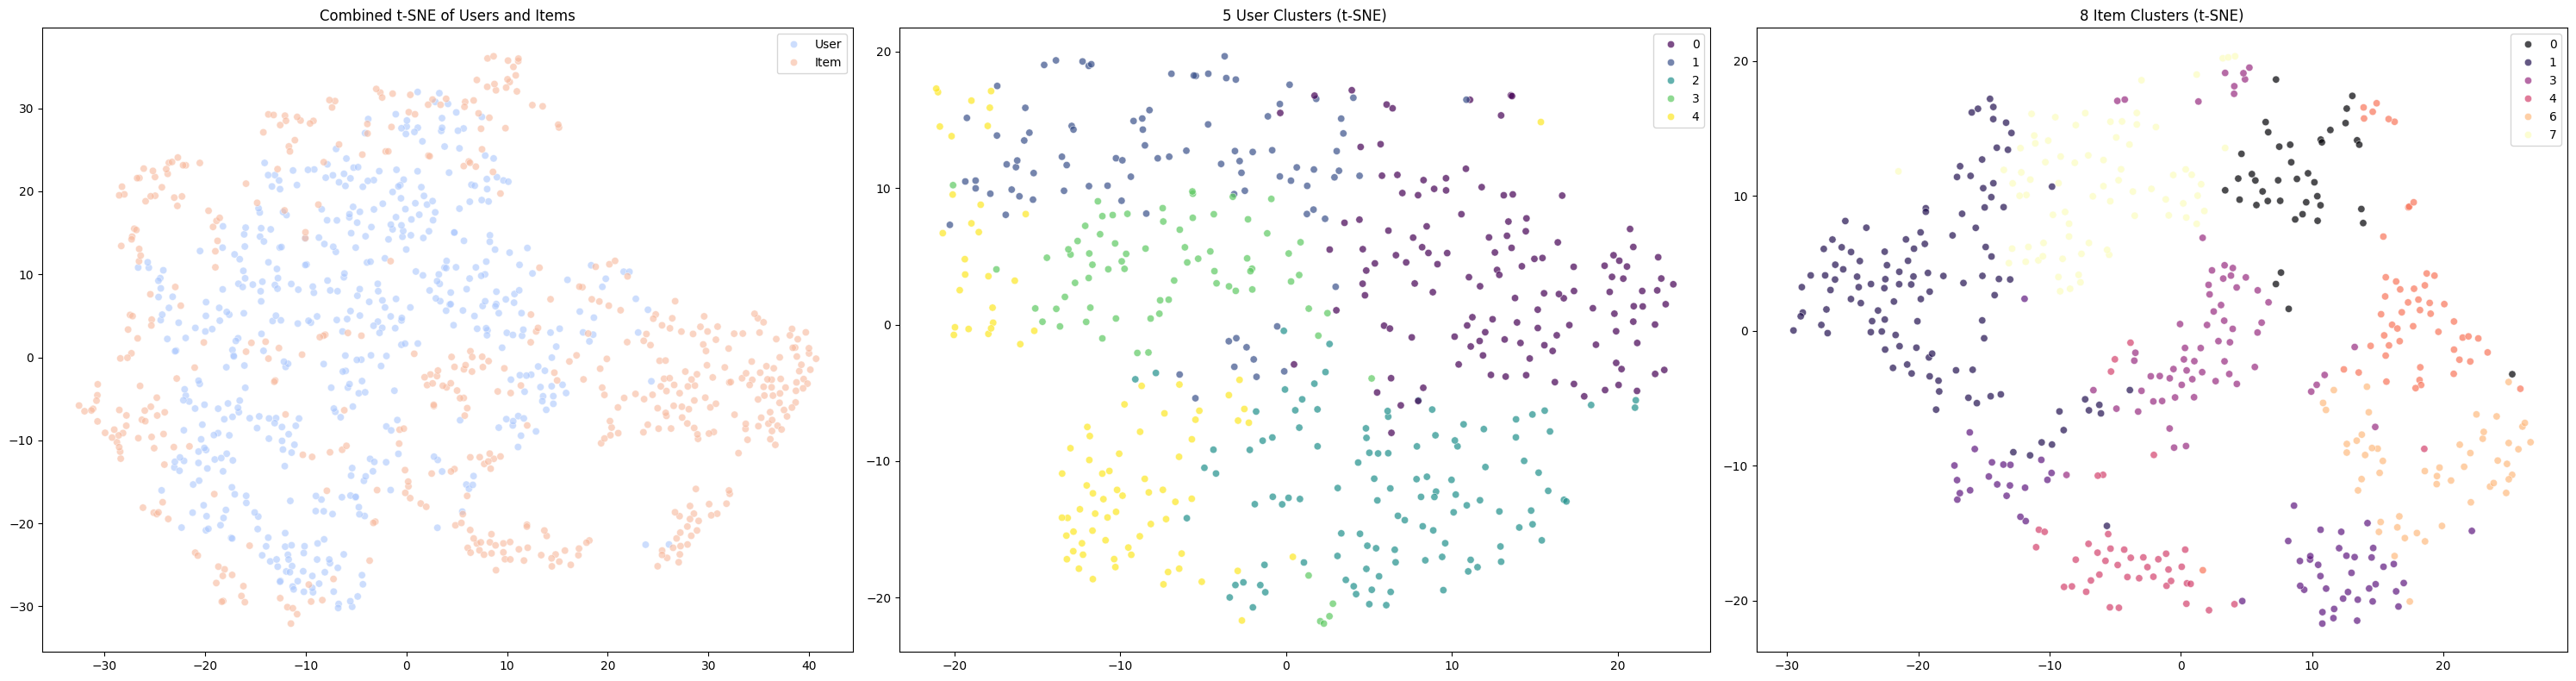


Analysis complete.


In [7]:
if __name__ == "__main__":
    # This script is configured to run in ANALYSIS-ONLY mode.
    # It assumes you have already trained your models and have the
    # 'best_lightgcn_... .pth' files saved in your project directory.

    print("--- Setting up environment for ANALYSIS-ONLY run ---")

    # 1. The Config object is required to build the model with the correct architecture.
    #    (e.g., latent_dim=256)
    config = Config()

    # 2. We still need to ensure the dataset files exist on disk.
    #    The Loader needs them to get the number of users and items for each dataset.
    #    These functions will just check for the files and skip if they already exist.
    print("\nVerifying dataset files...")
    setup_datasets()
    download_ml_1m_dataset()
    # The 'create_ml1m_predefined_split' is also a data setup step
    create_ml1m_predefined_split()
    print("Dataset verification complete.")

    # 3. Run the analysis function.
    #    This will now load your saved .pth files and analyze them one by one.
    analyze_lightgcn_models()

    print("\nAnalysis complete.")